In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import sklearn
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Load necessary datasets

In [2]:
#load mutations table for RNAP
mutations = pd.read_csv('data/RNAP_MUTATIONS.csv')
mutations

,UNIQUEID,GENE,MUTATION,REF,ALT,NUCLEOTIDE_NUMBER,NUCLEOTIDE_INDEX,GENE_POSITION,CODES_PROTEIN,INDEL_LENGTH,INDEL_NUCLEOTIDES,AMINO_ACID_NUMBER,AMINO_ACID_SEQUENCE,NUMBER_NUCLEOTIDE_CHANGES,IS_MINOR_ALLELE,MINOR_MUTATION,FRS
0,site.01.subj.DR0682.lab.DR0682.iso.1,rpoB,S450L,tcg,ttg,NaN,NaN,450.0,True,NaN,NaN,450.0,L,1.0,False,NaN,NaN
1,site.01.subj.DR0682.lab.DR0682.iso.1,rpoB,A1075A,gct,gcc,NaN,NaN,1075.0,True,NaN,NaN,1075.0,A,1.0,False,NaN,NaN
2,site.01.subj.DR0674.lab.DR0674.iso.1,rpoB,S450L,tcg,ttg,NaN,NaN,450.0,True,NaN,NaN,450.0,L,1.0,False,NaN,NaN
3,site.01.subj.DR0674.lab.DR0674.iso.1,rpoB,E561E,gag,gaa,NaN,NaN,561.0,True,NaN,NaN,561.0,E,1.0,False,NaN,NaN
4,site.01.subj.DR0134.lab.DR0134.iso.1,rpoB,S450L,tcg,ttg,NaN,NaN,450.0,True,NaN,NaN,450.0,L,1.0,False,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176550,site.07.subj.718655D6-1333-4F67-AABF-09C7E521D...,rpoB,1326_del_gttgaccca,NaN,NaN,1326.0,761132.0,1326.0,True,-9.0,gttgaccca,NaN,NaN,NaN,False,NaN,NaN
176551,site.07.subj.718655D6-1333-4F67-AABF-09C7E521D...,rpoC,A172V,gcc,gtc,NaN,NaN,172.0,True,NaN,NaN,172.0,V,1.0,False,NaN,NaN
176552,site.07.subj.718655D6-1333-4F67-AABF-09C7E521D...,rpoC,R173R,cgg,agg,NaN,NaN,173.0,True,NaN,NaN,173.0,R,1.0,False,NaN,NaN
176553,site.07.subj.718655D6-1333-4F67-AABF-09C7E521D...,rpoC,P601L,ccg,ctg,NaN,NaN,601.0,True,NaN,NaN,601.0,L,1.0,False,NaN,NaN


In [3]:
#load known resistance mutations from EFFECTS table
effects = pd.read_pickle('data/EFFECTS.pkl.gz')
effects.reset_index(inplace = True)
effects['GENE_MUTATION'] = effects['GENE'].astype(str) + '_' + effects['MUTATION']
effects = effects[(effects.DRUG=='RIF') & (effects.PREDICTION=='R') 
                  & (~effects.MUTATION.str[-1].isin(['O','X']))]

resistance_mutations = effects.GENE_MUTATION.unique()
len(resistance_mutations)

128

In [4]:
#load conservative list of CMs from previous paper
CMs = pd.read_csv('data/final_CM_hit_list.csv')
CMs = CMs[CMs.homoplasy == True]
CMs

compensatory_mutations = CMs['putative CM'].unique()
len(compensatory_mutations)

51

In [5]:
#add resistance and compensatory mutation flags to mutations table: need to check for minor allele before concatenating GENE_MUTATION 
# use resistance catalogue of WHO instead?
mutations['GENE_MUTATION'] = np.where(
    mutations['IS_MINOR_ALLELE'],  # Condition: if IS_MINOR_ALLELE is True
    mutations['GENE'].astype(str) + '_' + mutations['MINOR_MUTATION'].astype(str),  # Then: use GENE + MINOR_MUTATION
    mutations['GENE'].astype(str) + '_' + mutations['MUTATION'].astype(str)  # Else: use GENE + MUTATION
)
    
mutations['RESISTANT_MUTATION'] = mutations['GENE_MUTATION'].isin(resistance_mutations)
mutations['COMPENSATORY_MUTATION'] = mutations['GENE_MUTATION'].isin(compensatory_mutations)

mutations

,UNIQUEID,GENE,MUTATION,REF,ALT,NUCLEOTIDE_NUMBER,NUCLEOTIDE_INDEX,GENE_POSITION,CODES_PROTEIN,INDEL_LENGTH,INDEL_NUCLEOTIDES,AMINO_ACID_NUMBER,AMINO_ACID_SEQUENCE,NUMBER_NUCLEOTIDE_CHANGES,IS_MINOR_ALLELE,MINOR_MUTATION,FRS,GENE_MUTATION,RESISTANT_MUTATION,COMPENSATORY_MUTATION
0,site.01.subj.DR0682.lab.DR0682.iso.1,rpoB,S450L,tcg,ttg,NaN,NaN,450.0,True,NaN,NaN,450.0,L,1.0,False,NaN,NaN,rpoB_S450L,True,False
1,site.01.subj.DR0682.lab.DR0682.iso.1,rpoB,A1075A,gct,gcc,NaN,NaN,1075.0,True,NaN,NaN,1075.0,A,1.0,False,NaN,NaN,rpoB_A1075A,False,False
2,site.01.subj.DR0674.lab.DR0674.iso.1,rpoB,S450L,tcg,ttg,NaN,NaN,450.0,True,NaN,NaN,450.0,L,1.0,False,NaN,NaN,rpoB_S450L,True,False
3,site.01.subj.DR0674.lab.DR0674.iso.1,rpoB,E561E,gag,gaa,NaN,NaN,561.0,True,NaN,NaN,561.0,E,1.0,False,NaN,NaN,rpoB_E561E,False,False
4,site.01.subj.DR0134.lab.DR0134.iso.1,rpoB,S450L,tcg,ttg,NaN,NaN,450.0,True,NaN,NaN,450.0,L,1.0,False,NaN,NaN,rpoB_S450L,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176550,site.07.subj.718655D6-1333-4F67-AABF-09C7E521D...,rpoB,1326_del_gttgaccca,NaN,NaN,1326.0,761132.0,1326.0,True,-9.0,gttgaccca,NaN,NaN,NaN,False,NaN,NaN,rpoB_1326_del_gttgaccca,True,False
176551,site.07.subj.718655D6-1333-4F67-AABF-09C7E521D...,rpoC,A172V,gcc,gtc,NaN,NaN,172.0,True,NaN,NaN,172.0,V,1.0,False,NaN,NaN,rpoC_A172V,False,False
176552,site.07.subj.718655D6-1333-4F67-AABF-09C7E521D...,rpoC,R173R,cgg,agg,NaN,NaN,173.0,True,NaN,NaN,173.0,R,1.0,False,NaN,NaN,rpoC_R173R,False,False
176553,site.07.subj.718655D6-1333-4F67-AABF-09C7E521D...,rpoC,P601L,ccg,ctg,NaN,NaN,601.0,True,NaN,NaN,601.0,L,1.0,False,NaN,NaN,rpoC_P601L,False,False


In [6]:
#add phenotypes flag to mutations table (filter out low quality phenotypes)
phenotypes = pd.read_pickle('data/DST_MEASUREMENTS.pkl.gz')
phenotypes.reset_index(inplace = True)
phenotypes = phenotypes[(phenotypes.DRUG == 'RIF')] #  & (phenotypes.QUALITY != 'LOW')
phenotypes

#merge mutations and phenotypes tables, can also do a left join to keep samples without phenotypes (might be useful for CM statistics)
mutations_phenotypes = pd.merge(mutations, phenotypes[['UNIQUEID','PHENOTYPE','QUALITY']], on = 'UNIQUEID', how = 'inner')
mutations_phenotypes['PHENOTYPE'] = mutations_phenotypes['PHENOTYPE'] == 'R'

#drop UNIQUEIDs with phenotypes of low quality
low_quality_ids = mutations_phenotypes[mutations_phenotypes['QUALITY'] == 'LOW']['UNIQUEID'].unique()
mutations_phenotypes = mutations_phenotypes[~mutations_phenotypes['UNIQUEID'].isin(low_quality_ids)]

mutations_phenotypes = mutations_phenotypes.drop(columns = ['QUALITY'])
print(len(mutations_phenotypes.UNIQUEID.unique()))

28052


Calculate sensitivity and specificity of RIF resistance in all samples using different FRS scores

In [7]:
# aggregate mutations_phenotype by UNIQUEID and keep columns of interest: included new definition of FRS
def aggregate_minor_major_allele(group):
    # Check if any row has both IS_MINOR_ALLELE == True and RESISTANT_MUTATION == True
    minor_allele_flag = any((group['IS_MINOR_ALLELE'] == True) & (group['RESISTANT_MUTATION'] == True))
    major_allele_flag = any((group['IS_MINOR_ALLELE'] == False) & (group['RESISTANT_MUTATION'] == True))

    # Get the rows where there is a resistant minor allele
    resistant_minor_allele_rows = group[(group['IS_MINOR_ALLELE'] == True) & (group['RESISTANT_MUTATION'] == True)]
    
    if not resistant_minor_allele_rows.empty:
        # If there are resistant minor alleles, get the maximum FRS value for those rows
        frs_value = resistant_minor_allele_rows['FRS'].max()
    else:
        # Otherwise, use the maximum FRS value from the entire group
        frs_value = group['FRS'].max()
    
    return pd.Series({
        'RESISTANT_MUTATION': group['RESISTANT_MUTATION'].max(),
        'COMPENSATORY_MUTATION': group['COMPENSATORY_MUTATION'].max(),
        'PHENOTYPE': group['PHENOTYPE'].max(),
        'R_MINOR_ALLELE': minor_allele_flag,
        'R_MAJOR_ALLELE': major_allele_flag,
        'FRS': frs_value,  # Use the maximum FRS for resistant minor alleles, if present
    })

# Apply the custom aggregation function
mutations_agg_phen = mutations_phenotypes.groupby('UNIQUEID').apply(aggregate_minor_major_allele).reset_index()

/var/folders/_3/8y_dwngx2614_y_52fzh1c4w0000gn/T/ipykernel_58588/1777167371.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mutations_agg_phen = mutations_phenotypes.groupby('UNIQUEID').apply(aggregate_minor_major_allele).reset_index()


In [8]:
# define function for calculating sensitivity, specificity, PPV and NPV
#calculate sensitivity: number of phenotypically resistant samples that are found to have a resistant mutation / total number of phenotypically resistant samples
#calculate specificity: number of phenotypically sensitive samples that do not have a resistance mutation / total number of phenotypically sensitive samples
#calculate PPV: number of samples with a resistance mutation that are phenotypically resistant / total number of samples with a resistance mutation
#calculate NPV: number of samples without a resistance mutation that are phenotypically sensitive / total number of samples without a resistance mutation

def calculate_statistics(df):
    sensitivity = df[(df['PHENOTYPE'] == True) & (df['RESISTANT_MUTATION'] == True)].shape[0] / df[df['PHENOTYPE'] == True].shape[0]
    specificity = df[(df['PHENOTYPE'] == False) & (df['RESISTANT_MUTATION'] == False)].shape[0] / df[df['PHENOTYPE'] == False].shape[0]
    PPV = df[(df['RESISTANT_MUTATION'] == True) & (df['PHENOTYPE'] == True)].shape[0] / df[df['RESISTANT_MUTATION'] == True].shape[0]
    NPV = df[(df['RESISTANT_MUTATION'] == False) & (df['PHENOTYPE'] == False)].shape[0] / df[df['RESISTANT_MUTATION'] == False].shape[0]
    return sensitivity, specificity, PPV, NPV

In [9]:
#calculate statistics for no FRS cutoff
print(mutations_agg_phen.RESISTANT_MUTATION.value_counts())
sen_all, spe_all, ppv_all, npv_all = calculate_statistics(mutations_agg_phen)
sen_all, spe_all, ppv_all, npv_all

RESISTANT_MUTATION
False    17302
True     10750
Name: count, dtype: int64


(0.971577223239233, 0.96231539636734, 0.938046511627907, 0.9829499479828921)

In [10]:
#calculate statistics for FRS cutoff >=0.9 (major allele definition)
major_mutations = mutations_agg_phen.copy()
major_mutations['RESISTANT_MUTATION'] = major_mutations['R_MAJOR_ALLELE']
print(major_mutations.RESISTANT_MUTATION.value_counts())
sen_maj, spe_maj, ppv_maj, npv_maj = calculate_statistics(major_mutations)
sen_maj, spe_maj, ppv_maj, npv_maj

RESISTANT_MUTATION
False    17566
True     10486
Name: count, dtype: int64


(0.9501878793718085, 0.964691902902733, 0.940492084684341, 0.9705681430035296)

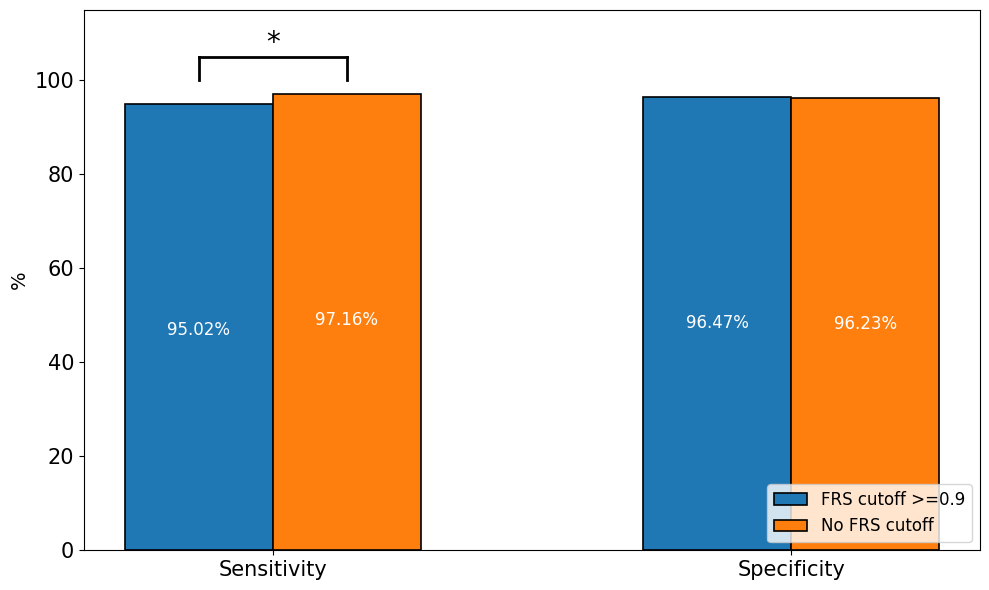

In [11]:
# plot sensitivity and specificity for no FRS cutoff and for FRS cutoff >=0.9 (major allele definition) as a histogram
def create_stats_df(sen_1, sen_2, spe_1, spe_2):
    stats = pd.DataFrame({
        'Metric': ['Sensitivity', 'Specificity'],
        'FRS cutoff >=0.9 (major allele definition)': [sen_1, spe_1],
        'No FRS cutoff': [sen_2, spe_2]
    })
    return stats


def plot_stats_histogram(stats, significant = True, save_figure=False, save_name='sensitivity_specificity_histogram', legend_label_1 = 'FRS cutoff >=0.9', legen_label_2 = 'No FRS cutoff'):
    # Adjusting the plot to group bars by criteria and display percentage inside the bar
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plotting bars next to each other
    x = [0, 0.7]  # positions for FRS cutoff >=0.9 (major allele definition)
    bar_width = 0.2

    bars1 = ax.bar(x, stats['FRS cutoff >=0.9 (major allele definition)'], 
                width=bar_width, color='#1f77b4', edgecolor='black', linewidth=1.2, label=legend_label_1)
    bars2 = ax.bar([p + bar_width for p in x], stats['No FRS cutoff'], 
                width=bar_width, color='#ff7f0e', edgecolor='black', linewidth=1.2, label=legen_label_2)

    # Adding percentage values inside the bars
    for bars in [bars1, bars2]:
        for bar in bars:
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, yval - 0.5, f'{yval:.2%}', 
                    ha='center', va='bottom', fontsize=12, color='white')

    # Customize the plot
    # Set y-axis to display values as percentages without the percent sign
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0f}'.format(y * 100)))

    # ax.set_title('Sensitivity and Specificity for Rifampicin Resistance', fontsize=18)
    ax.set_ylabel('%', fontsize=14)
    ax.set_ylim(0, 1.15)

    # Setting custom x-axis labels
    ax.set_xticks([r + bar_width/2 for r in x])
    ax.set_xticklabels(['Sensitivity', 'Specificity'], fontsize=15)

    # Increase axis fontsizes
    ax.tick_params(axis='both', which='major', labelsize=15)

    # Adding the legend
    ax.legend(loc='lower right', fontsize=12)

    #add significance indicator with horizontal bar between bars of sensitivity
    if significant:
        ax.plot([0, 0], [1, 1.05], color='black', lw=2)
        ax.plot([0.2, 0.2], [1, 1.05], color='black', lw=2)
        ax.plot([0, 0.2], [1.05, 1.05], color='black', lw=2)
        ax.text(0.1, 1.08, '*', fontsize=20, color='black', ha='center', va='center')

    plt.tight_layout()
    plt.show()

    #save figure if print_stats is True
    if save_figure:
        fig.savefig(f'figures/{save_name}.png', dpi=300)


stats = create_stats_df(sen_maj, sen_all, spe_maj, spe_all)
plot_stats_histogram(stats, significant = True, save_figure=True, save_name = 'sensitivity_specificity_histogram')

In [13]:
#perform a z test to test for significant difference between the sensitivities and specificities
from statsmodels.stats.proportion import proportions_ztest

# Sensitivity
count = np.array([mutations_agg_phen[(mutations_agg_phen['PHENOTYPE'] == True) & (mutations_agg_phen['RESISTANT_MUTATION'] == True)].shape[0], major_mutations[(major_mutations['PHENOTYPE'] == True) & (major_mutations['RESISTANT_MUTATION'] == True)].shape[0]])
nobs = np.array([mutations_agg_phen[mutations_agg_phen['PHENOTYPE'] == True].shape[0], major_mutations[major_mutations['PHENOTYPE'] == True].shape[0]])
z, p = proportions_ztest(count, nobs)
print(count, nobs, z, p)

# Specificity
count = np.array([mutations_agg_phen[(mutations_agg_phen['PHENOTYPE'] == False) & (mutations_agg_phen['RESISTANT_MUTATION'] == False)].shape[0], major_mutations[(major_mutations['PHENOTYPE'] == False) & (major_mutations['RESISTANT_MUTATION'] == False)].shape[0]])
nobs = np.array([mutations_agg_phen[mutations_agg_phen['PHENOTYPE'] == False].shape[0], major_mutations[major_mutations['PHENOTYPE'] == False].shape[0]])
z, p = proportions_ztest(count, nobs)
print(count, nobs, z, p)


[10084  9862] [10379 10379] 7.947669635398789 1.9005266452625613e-15
[17007 17049] [17673 17673] -1.1913181357783043 0.23352871690872834


In [14]:
#calculate statistics for FRS cutoff >=0.5 
minor_cutoff = mutations_agg_phen.copy()
minor_cutoff['RESISTANT_MUTATION'] = ((minor_cutoff['FRS'] >= 0.0) & (minor_cutoff['R_MINOR_ALLELE'] == True)) | (minor_cutoff['R_MAJOR_ALLELE'] == True)
print(minor_cutoff.RESISTANT_MUTATION.value_counts())
calculate_statistics(minor_cutoff)

RESISTANT_MUTATION
False    17302
True     10750
Name: count, dtype: int64


(0.971577223239233, 0.96231539636734, 0.938046511627907, 0.9829499479828921)

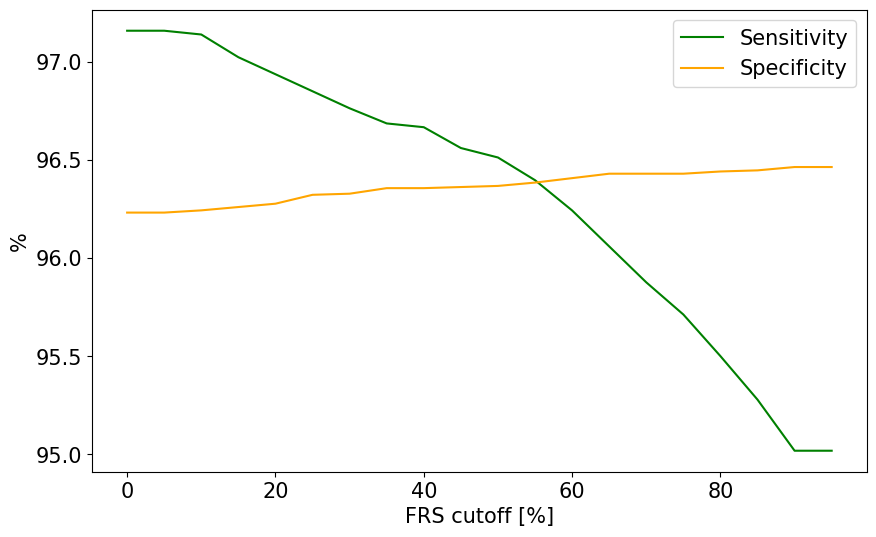

In [15]:
#plot the sensitivity for different FRS cutoffs
sensitivity = []
specificity = []
PPV = []
NPV = []
FRS = []

for i in range(0, 100, 5):
    cutoff = i/100
    df = mutations_agg_phen.copy()

    # assign RESISTANT_MUTATION column to True if FRS is >= cutoff while R_MINOR_ALLELE is True or if R_MAJOR_ALLELE is True
    df['RESISTANT_MUTATION'] = ((df['FRS'] >= cutoff) & (df['R_MINOR_ALLELE'] == True)) | (df['R_MAJOR_ALLELE'] == True)

    # df = df[(df.FRS.isna())|(df.FRS>=cutoff)]

    # calculate_statistics(df)
    sensitivity.append(df[(df['PHENOTYPE'] == True) & (df['RESISTANT_MUTATION'] == True)].shape[0] / df[df['PHENOTYPE'] == True].shape[0])
    specificity.append(df[(df['PHENOTYPE'] == False) & (df['RESISTANT_MUTATION'] == False)].shape[0] / df[df['PHENOTYPE'] == False].shape[0])
    # PPV.append(df[(df['RESISTANT_MUTATION'] == True) & (df['PHENOTYPE'] == True)].shape[0] / df[df['RESISTANT_MUTATION'] == True].shape[0])
    # NPV.append(df[(df['RESISTANT_MUTATION'] == False) & (df['PHENOTYPE'] == False)].shape[0] / df[df['RESISTANT_MUTATION'] == False].shape[0])
    FRS.append(cutoff)


fig, ax1 = plt.subplots(figsize=(10, 6))

#plot sensitivity and specificity using one y axis
plt.plot(FRS, sensitivity, label = 'Sensitivity', color = 'green')
plt.plot(FRS, specificity, label = 'Specificity', color = 'orange') 
plt.legend(fontsize=15)
plt.xlabel('FRS cutoff [%]', fontsize=15)
plt.ylabel('%', fontsize=15)
# plt.title('Sensitivity and Specificity for different FRS cutoffs')

#increase tick label sizes
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Set axes to display values as percentages without the percent sign
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.1f}'.format(y * 100)))
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f}'.format(x * 100)))

# #save figure in high resolution
plt.savefig('figures/sensitivity_specificity_FRS_cutoff.png', dpi=300)

plt.show()

Check how much presence of CMs can improve predictions (with and without considering minor alleles)

In [16]:
#calculate statistics for CMs indicating resistance, excluding minor alleles
CM_mutations = mutations_agg_phen.copy()
CM_mutations['RESISTANT_MUTATION'] = (CM_mutations['COMPENSATORY_MUTATION'] == True) | (CM_mutations['R_MAJOR_ALLELE'] == True)
print(CM_mutations.RESISTANT_MUTATION.value_counts())
sen_CM_maj, spe_CM_maj, ppv_CM_maj, npv_CM_maj = calculate_statistics(CM_mutations)
sen_CM_maj, spe_CM_maj, ppv_CM_maj, npv_CM_maj

RESISTANT_MUTATION
False    17540
True     10512
Name: count, dtype: int64


(0.9523075440793911,
 0.9644655689469813,
 0.9402587519025876,
 0.9717787913340935)

In [17]:
#calculate statistics for FRS cutoff >=0.9 (major allele definition) without considering CMs
major_mutations = mutations_agg_phen.copy()
major_mutations['RESISTANT_MUTATION'] = major_mutations['R_MAJOR_ALLELE']
print(major_mutations.RESISTANT_MUTATION.value_counts())
sen_maj, spe_maj, ppv_maj, npv_maj = calculate_statistics(major_mutations)
sen_maj, spe_maj, ppv_maj, npv_maj

RESISTANT_MUTATION
False    17566
True     10486
Name: count, dtype: int64


(0.9501878793718085, 0.964691902902733, 0.940492084684341, 0.9705681430035296)

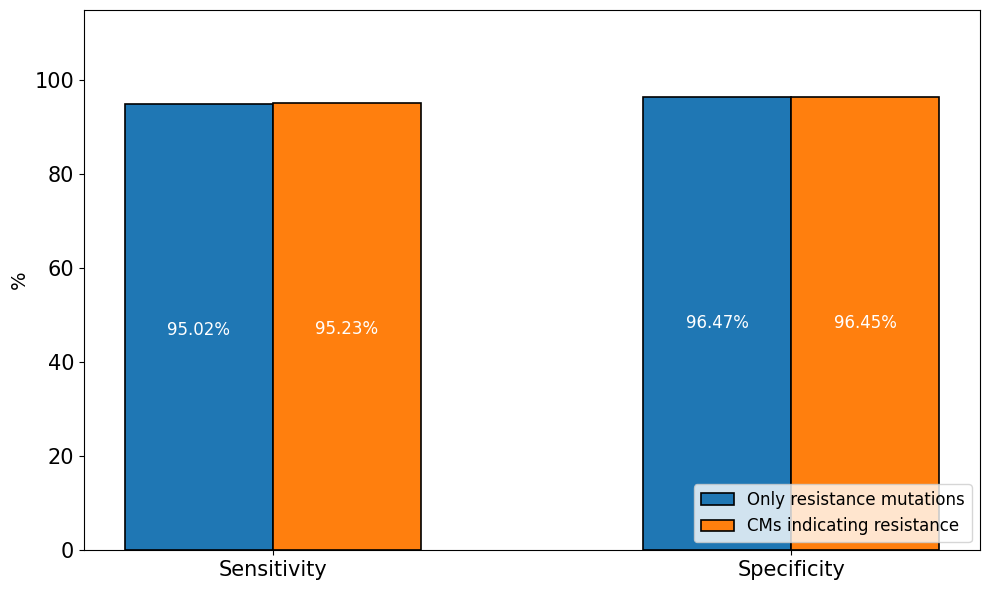

In [18]:
stats = create_stats_df(sen_maj, sen_CM_maj, spe_maj, spe_CM_maj)
plot_stats_histogram(stats, significant = False, save_figure=True, save_name = 'sensitivity_specificity_histogram_CM', legend_label_1='Only resistance mutations', legen_label_2='CMs indicating resistance')

In [19]:
#perform a z test to test for significant difference between the sensitivities and specificities
from statsmodels.stats.proportion import proportions_ztest

# Sensitivity
count = np.array([major_mutations[(major_mutations['PHENOTYPE'] == True) & (major_mutations['RESISTANT_MUTATION'] == True)].shape[0], CM_mutations[(CM_mutations['PHENOTYPE'] == True) & (CM_mutations['RESISTANT_MUTATION'] == True)].shape[0]])
nobs = np.array([major_mutations[major_mutations['PHENOTYPE'] == True].shape[0], CM_mutations[CM_mutations['PHENOTYPE'] == True].shape[0]])
z, p = proportions_ztest(count, nobs)
print(count, nobs, z, p)

# Specificity
count = np.array([major_mutations[(major_mutations['PHENOTYPE'] == False) & (major_mutations['RESISTANT_MUTATION'] == False)].shape[0], CM_mutations[(CM_mutations['PHENOTYPE'] == False) & (CM_mutations['RESISTANT_MUTATION'] == False)].shape[0]])
nobs = np.array([major_mutations[major_mutations['PHENOTYPE'] == False].shape[0], CM_mutations[CM_mutations['PHENOTYPE'] == False].shape[0]])
z, p = proportions_ztest(count, nobs)
print(count, nobs, z, p)


[9862 9884] [10379 10379] -0.709064286924491 0.4782845838113805
[17049 17045] [17673 17673] 0.1151036207073956 0.9083629900717725


In [20]:
#calculate statistics for CMs indicating resistance, including minor alleles
CM_mutations_minor = mutations_agg_phen.copy()
CM_mutations_minor['RESISTANT_MUTATION'] = (CM_mutations_minor['COMPENSATORY_MUTATION'] == True) | (CM_mutations_minor['RESISTANT_MUTATION'] == True)
print(CM_mutations_minor.RESISTANT_MUTATION.value_counts())
sen_CM_all, spe_CM_all, ppv_CM_all, npv_CM_all = calculate_statistics(CM_mutations_minor)
sen_CM_all, spe_CM_all, ppv_CM_all, npv_CM_all

RESISTANT_MUTATION
False    17288
True     10764
Name: count, dtype: int64


(0.9728297523846228, 0.9622588128784021, 0.938034188034188, 0.9836881073577047)

In [21]:
#calculate statistics for no FRS cutoff, without considering CMs
print(mutations_agg_phen.RESISTANT_MUTATION.value_counts())
sen_all, spe_all, ppv_all, npv_all = calculate_statistics(mutations_agg_phen)
sen_all, spe_all, ppv_all, npv_all

RESISTANT_MUTATION
False    17302
True     10750
Name: count, dtype: int64


(0.971577223239233, 0.96231539636734, 0.938046511627907, 0.9829499479828921)

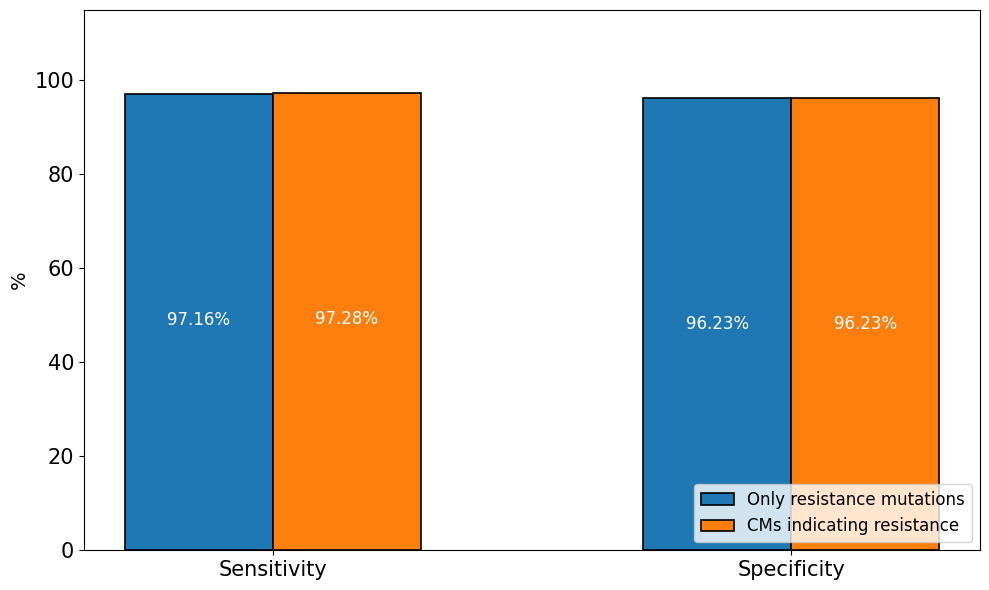

In [22]:
stats = create_stats_df(sen_all, sen_CM_all, spe_all, spe_CM_all)
plot_stats_histogram(stats, significant = False, save_figure=True, save_name = 'sensitivity_specificity_histogram_CM_minor', legend_label_1='Only resistance mutations', legen_label_2='CMs indicating resistance')

In [23]:
#perform a z test to test for significant difference between the sensitivities and specificities
from statsmodels.stats.proportion import proportions_ztest

# Sensitivity
count = np.array([mutations_agg_phen[(mutations_agg_phen['PHENOTYPE'] == True) & (mutations_agg_phen['RESISTANT_MUTATION'] == True)].shape[0], CM_mutations_minor[(CM_mutations_minor['PHENOTYPE'] == True) & (CM_mutations_minor['RESISTANT_MUTATION'] == True)].shape[0]])
nobs = np.array([mutations_agg_phen[mutations_agg_phen['PHENOTYPE'] == True].shape[0], CM_mutations_minor[CM_mutations_minor['PHENOTYPE'] == True].shape[0]])
z, p = proportions_ztest(count, nobs)
print(count, nobs, z, p)

# Specificity
count = np.array([mutations_agg_phen[(mutations_agg_phen['PHENOTYPE'] == False) & (mutations_agg_phen['RESISTANT_MUTATION'] == False)].shape[0], CM_mutations_minor[(CM_mutations_minor['PHENOTYPE'] == False) & (CM_mutations_minor['RESISTANT_MUTATION'] == False)].shape[0]])
nobs = np.array([mutations_agg_phen[mutations_agg_phen['PHENOTYPE'] == False].shape[0], CM_mutations_minor[CM_mutations_minor['PHENOTYPE'] == False].shape[0]])
z, p = proportions_ztest(count, nobs)
print(count, nobs, z, p)

[10084 10097] [10379 10379] -0.5488793074361511 0.5830882796172004
[17007 17006] [17673 17673] 0.027921104387451576 0.9777250761371025


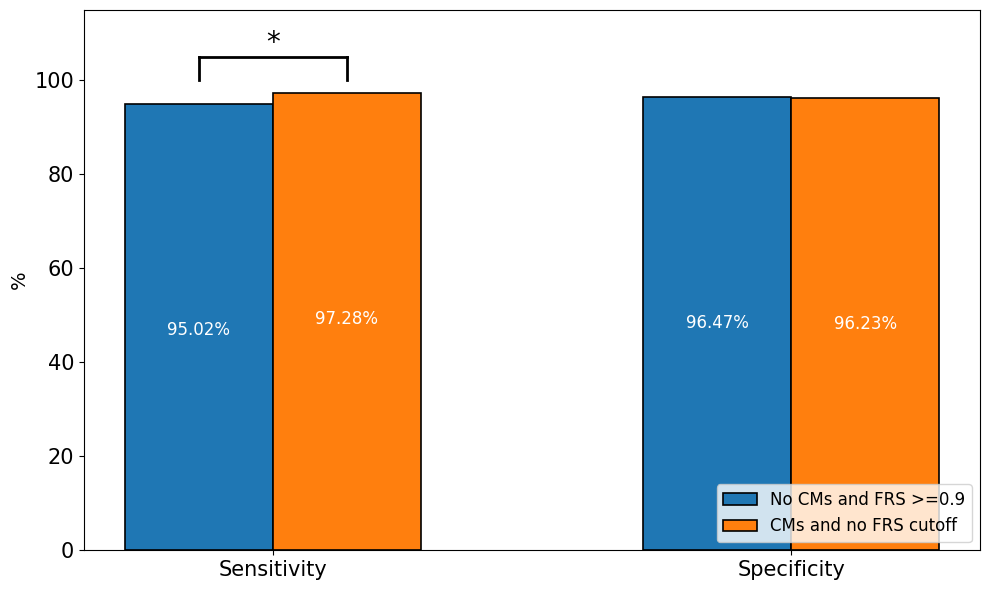

In [24]:
#Lastly, compare the sensitivity and specificity for FRS cutoff >=0.9 (major allele definition) without considering CMs with the sensitivity and specificity for CMs and minor alleles indicating resistance
stats = create_stats_df(sen_maj, sen_CM_all, spe_maj, spe_CM_all)
plot_stats_histogram(stats, significant = True, save_figure=True, save_name = 'sensitivity_specificity_histogram_all_vs_major', legend_label_1='No CMs and FRS >=0.9', legen_label_2='CMs and no FRS cutoff')

Check how CM presence differs in major and minor allele populations

In [25]:
# aggregate mutations_phenotype by UNIQUEID and keep columns of interest: double-check if definiion of FRS is correct
def aggregate_minor_major_allele(group):
    # Check if any row has both IS_MINOR_ALLELE == True and RESISTANT_MUTATION == True
    minor_allele_flag = any((group['IS_MINOR_ALLELE'] == True) & (group['RESISTANT_MUTATION'] == True))
    major_allele_flag = any((group['IS_MINOR_ALLELE'] == False) & (group['RESISTANT_MUTATION'] == True))

    # Get the rows where there is a resistant minor allele
    resistant_minor_allele_rows = group[(group['IS_MINOR_ALLELE'] == True) & (group['RESISTANT_MUTATION'] == True)]
    
    if not resistant_minor_allele_rows.empty:
        # If there are resistant minor alleles, get the maximum FRS value for those rows
        frs_value = resistant_minor_allele_rows['FRS'].max()
    else:
        # Otherwise, use the maximum FRS value from the entire group
        frs_value = group['FRS'].max()
    
    return pd.Series({
        'RESISTANT_MUTATION': group['RESISTANT_MUTATION'].max(),
        'COMPENSATORY_MUTATION': group['COMPENSATORY_MUTATION'].max(),
        'R_MINOR_ALLELE': minor_allele_flag,
        'R_MAJOR_ALLELE': major_allele_flag,
        'FRS': frs_value,  # Use the maximum FRS for resistant minor alleles, if present
    })

# Apply the custom aggregation function
mutations_agg = mutations.groupby('UNIQUEID').apply(aggregate_minor_major_allele).reset_index()

/var/folders/_3/8y_dwngx2614_y_52fzh1c4w0000gn/T/ipykernel_58588/2026146715.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mutations_agg = mutations.groupby('UNIQUEID').apply(aggregate_minor_major_allele).reset_index()


In [26]:
mutations_agg
#save mutations_agg table
mutations_agg.to_csv('data/mutations_agg-UNIQUEID.csv', index = False)

In [27]:
#check overlap
overlap = mutations_agg[(mutations_agg['R_MAJOR_ALLELE'] == True) & (mutations_agg['R_MINOR_ALLELE'] == True)].UNIQUEID.to_list()
len(overlap)

30

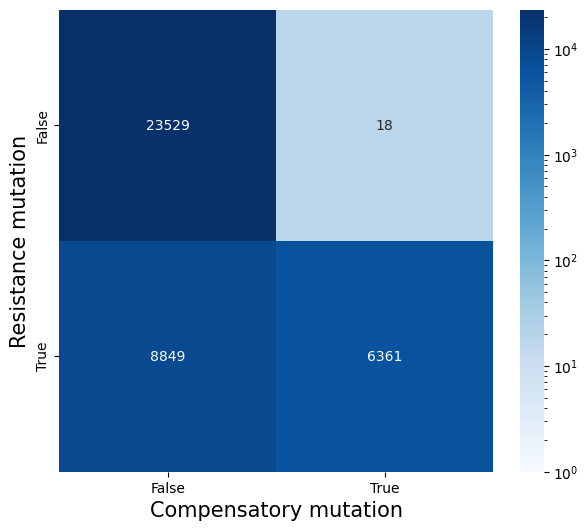

In [28]:
#make contingency matrix for samples based on resistance and compensatory mutations, exluding the overlap
from matplotlib.colors import LogNorm
def contingency_heatmap(df, overlap, save_name='contingency_heatmap.png'):
    contingency = pd.crosstab(df[~df['UNIQUEID'].isin(overlap)]['RESISTANT_MUTATION'], df[~df['UNIQUEID'].isin(overlap)]['COMPENSATORY_MUTATION'])
    contingency

    #show contingency matrix as heatmap in green colour, wihtout rounded values
    plt.figure(figsize=(7, 6))
    sns.heatmap(contingency, annot=True, fmt='d', cmap='Blues', 
                norm=LogNorm(vmin=1, vmax=contingency.max().max()), cbar=True)
    # plt.title('Contingency matrix for resistance and compensatory mutations')
    plt.xlabel('Compensatory mutation', fontsize=15)
    plt.ylabel('Resistance mutation', fontsize=15)

    #save figure in high resolution
    plt.savefig(f'figures/{save_name}', dpi=300)

    plt.show()

contingency_heatmap(mutations_agg, overlap, save_name='contingency_heatmap.png')

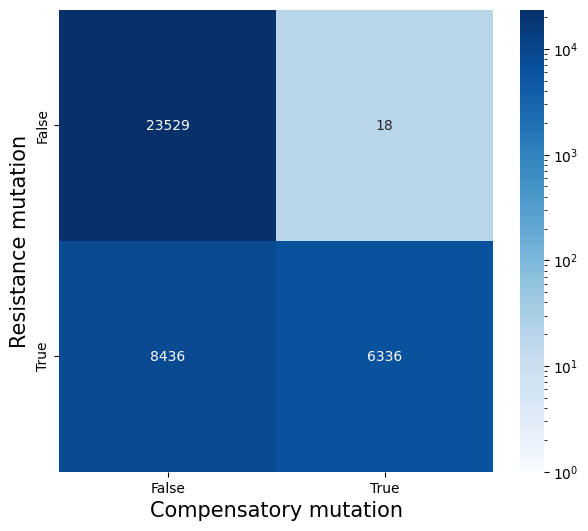

In [29]:
#exclude all samples with a minor allele from the analysis
mutations_agg_major = mutations_agg[~mutations_agg['R_MINOR_ALLELE']]
contingency_heatmap(mutations_agg_major, overlap, save_name='contingency_heatmap_major.png')


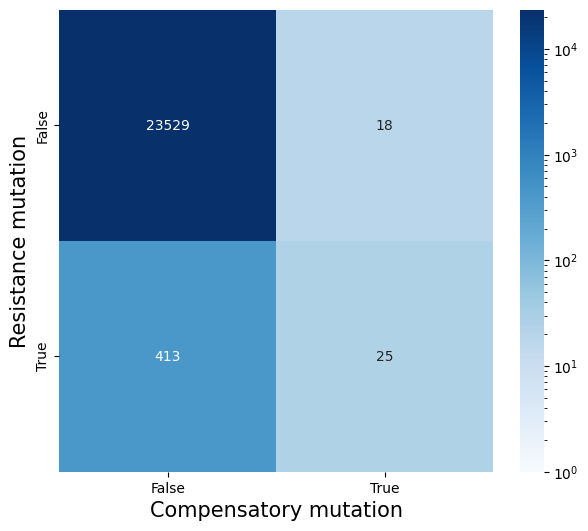

In [30]:
#exclude all samples with a resistant major allele from the analysis
mutations_agg_minor = mutations_agg[~mutations_agg['R_MAJOR_ALLELE']]
contingency_heatmap(mutations_agg_minor, overlap, save_name='contingency_heatmap_minor.png')

In [31]:
contingency_major = pd.crosstab(mutations_agg_major[~mutations_agg_major['UNIQUEID'].isin(overlap)]['RESISTANT_MUTATION'], mutations_agg_major[~mutations_agg_major['UNIQUEID'].isin(overlap)]['COMPENSATORY_MUTATION'])
contingency_major.iloc[1,1]/contingency_major.sum(axis=1)[1]

contingency_minor = pd.crosstab(mutations_agg_minor[~mutations_agg_minor['UNIQUEID'].isin(overlap)]['RESISTANT_MUTATION'], mutations_agg_minor[~mutations_agg_minor['UNIQUEID'].isin(overlap)]['COMPENSATORY_MUTATION'])
contingency_minor.iloc[1,1]/contingency_minor.sum(axis=1)[1]


/var/folders/_3/8y_dwngx2614_y_52fzh1c4w0000gn/T/ipykernel_58588/244543749.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  contingency_major.iloc[1,1]/contingency_major.sum(axis=1)[1]
/var/folders/_3/8y_dwngx2614_y_52fzh1c4w0000gn/T/ipykernel_58588/244543749.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  contingency_minor.iloc[1,1]/contingency_minor.sum(axis=1)[1]


np.float64(0.05707762557077625)

/var/folders/_3/8y_dwngx2614_y_52fzh1c4w0000gn/T/ipykernel_58588/2718738671.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  major_percentage = contingency_major.iloc[1,1]/contingency_major.sum(axis=1)[1]
/var/folders/_3/8y_dwngx2614_y_52fzh1c4w0000gn/T/ipykernel_58588/2718738671.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  minor_percentage = contingency_minor.iloc[1,1]/contingency_minor.sum(axis=1)[1]


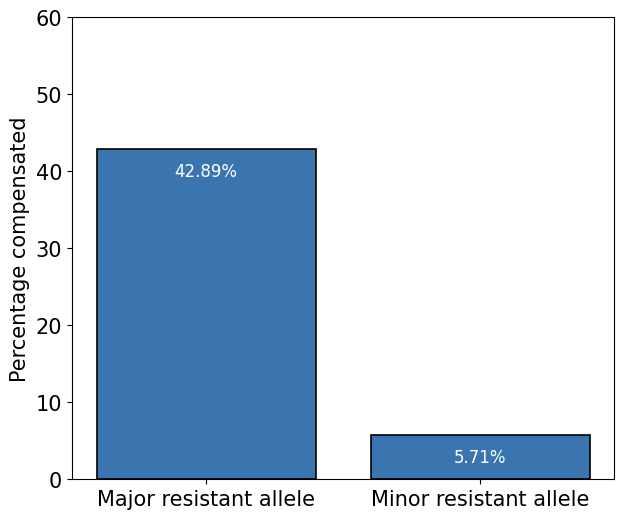

In [32]:
#make nice percentage plot of percentage of compensation in major vs minor resistant populations
#also plot the data as a bar plot of the lower row of the contingency matrix
def compensation_barplot(major_df, minor_df, save_name='contingency_barplot.png'):
    contingency_major = pd.crosstab(major_df[~major_df['UNIQUEID'].isin(overlap)]['RESISTANT_MUTATION'], major_df[~major_df['UNIQUEID'].isin(overlap)]['COMPENSATORY_MUTATION'])
    major_percentage = contingency_major.iloc[1,1]/contingency_major.sum(axis=1)[1]

    contingency_minor = pd.crosstab(minor_df[~minor_df['UNIQUEID'].isin(overlap)]['RESISTANT_MUTATION'], minor_df[~minor_df['UNIQUEID'].isin(overlap)]['COMPENSATORY_MUTATION'])
    minor_percentage = contingency_minor.iloc[1,1]/contingency_minor.sum(axis=1)[1]

    #plot the two percentages as a nice bar plot
    plt.figure(figsize=(7, 6))
    plt.bar(['Major resistant allele', 'Minor resistant allele'], [major_percentage, minor_percentage], color=['#3B75AF', '#3B75AF'], edgecolor='black', linewidth=1.2)
    plt.ylabel('Percentage compensated', fontsize=15)
    plt.ylim(0, 0.6)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

    #display percentages inside bars
    for i in range(2):
        plt.text(i, [major_percentage, minor_percentage][i] - 0.04, f'{[major_percentage, minor_percentage][i]:.2%}', ha='center', va='bottom', fontsize=12, color='white')

    # Set axes to display values as percentages without the percent sign
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0f}'.format(y * 100)))

    #save figure in high resolution
    plt.savefig(f'figures/{save_name}', dpi=300)

    plt.show()

compensation_barplot(mutations_agg_major, mutations_agg_minor, save_name='contingency_barplot.png')

Check if the CMs found in resistant minor populations have an FRS similar or lower than the resistance mutation FRS

In [33]:
#Get the Uniqueids of samples with a resistant minor allele and a compensatory mutation and no resistant major mutations 
# - should be the lower right corner of the contingency table
res_minor_CM_uniqueids = mutations_agg[(~mutations_agg.R_MAJOR_ALLELE == True) 
                                       & (mutations_agg.COMPENSATORY_MUTATION == True) & (mutations_agg.R_MINOR_ALLELE == True)].UNIQUEID
len(res_minor_CM_uniqueids)

25

In [34]:
#get the Uniqueids of samples with a resistant minor allele and a MINOR compensatory mutation and no resistant major mutations
res_minor_CM_minor_uniqueids = mutations[mutations.UNIQUEID.isin(res_minor_CM_uniqueids) & (mutations.COMPENSATORY_MUTATION == True) & (mutations.IS_MINOR_ALLELE == True)].UNIQUEID
len(res_minor_CM_minor_uniqueids)

13

In [35]:
#compare to number of minor compensatory mutations in whole dataset
mutations[(mutations.COMPENSATORY_MUTATION == True)].IS_MINOR_ALLELE.value_counts()

IS_MINOR_ALLELE
False    6347
True       44
Name: count, dtype: int64

In [36]:
resistance = mutations[(mutations.RESISTANT_MUTATION == True) & (mutations.UNIQUEID.isin(res_minor_CM_minor_uniqueids))]
resistance

,UNIQUEID,GENE,MUTATION,REF,ALT,NUCLEOTIDE_NUMBER,NUCLEOTIDE_INDEX,GENE_POSITION,CODES_PROTEIN,INDEL_LENGTH,INDEL_NUCLEOTIDES,AMINO_ACID_NUMBER,AMINO_ACID_SEQUENCE,NUMBER_NUCLEOTIDE_CHANGES,IS_MINOR_ALLELE,MINOR_MUTATION,FRS,GENE_MUTATION,RESISTANT_MUTATION,COMPENSATORY_MUTATION
20367,site.04.subj.00574.lab.706414.iso.1,rpoB,S450Z,tcg,zzz,NaN,NaN,450.0,True,NaN,NaN,450.0,L,1.0,True,S450L,0.441,rpoB_S450L,True,False
34371,site.04.subj.00622.lab.706166.iso.1,rpoB,D435Z,gac,zzz,NaN,NaN,435.0,True,NaN,NaN,435.0,Y,1.0,True,D435Y,0.758,rpoB_D435Y,True,False
34372,site.04.subj.00622.lab.706166.iso.1,rpoB,H445Z,cac,zzz,NaN,NaN,445.0,True,NaN,NaN,445.0,D,1.0,True,H445D,0.307,rpoB_H445D,True,False
50814,site.03.subj.T6596.lab.IML-00105.iso.1,rpoB,S450Z,tcg,zzz,NaN,NaN,450.0,True,NaN,NaN,450.0,L,1.0,True,S450L,0.198,rpoB_S450L,True,False
52171,site.03.subj.UZB16048.lab.UZB16048.iso.1,rpoB,S450Z,tcg,zzz,NaN,NaN,450.0,True,NaN,NaN,450.0,L,1.0,True,S450L,0.661,rpoB_S450L,True,False
59471,site.03.subj.UZB12040.lab.UZB12040.iso.1,rpoB,S450Z,tcg,zzz,NaN,NaN,450.0,True,NaN,NaN,450.0,L,1.0,True,S450L,0.318,rpoB_S450L,True,False
61659,site.03.subj.UZB9727.lab.UZB9727.iso.1,rpoB,S450Z,tcg,zzz,NaN,NaN,450.0,True,NaN,NaN,450.0,L,1.0,True,S450L,0.171,rpoB_S450L,True,False
62550,site.03.subj.UZB9723.lab.UZB9723.iso.1,rpoB,S450Z,tcg,zzz,NaN,NaN,450.0,True,NaN,NaN,450.0,L,1.0,True,S450L,0.258,rpoB_S450L,True,False
63973,site.03.subj.11409-95_LIB8605.lab.11409-95_LIB...,rpoB,1309_minorindel,NaN,NaN,1309.0,761115.0,1309.0,True,-3.0,aac,NaN,NaN,0.0,True,1309_del_aac,0.140,rpoB_1309_del_aac,True,False
63976,site.03.subj.11409-95_LIB8605.lab.11409-95_LIB...,rpoB,S450Z,tcg,zzz,NaN,NaN,450.0,True,NaN,NaN,450.0,L,1.0,True,S450L,0.837,rpoB_S450L,True,False


In [37]:
compensatory = mutations[mutations.UNIQUEID.isin(res_minor_CM_minor_uniqueids) & (mutations.COMPENSATORY_MUTATION == True)]
compensatory

,UNIQUEID,GENE,MUTATION,REF,ALT,NUCLEOTIDE_NUMBER,NUCLEOTIDE_INDEX,GENE_POSITION,CODES_PROTEIN,INDEL_LENGTH,INDEL_NUCLEOTIDES,AMINO_ACID_NUMBER,AMINO_ACID_SEQUENCE,NUMBER_NUCLEOTIDE_CHANGES,IS_MINOR_ALLELE,MINOR_MUTATION,FRS,GENE_MUTATION,RESISTANT_MUTATION,COMPENSATORY_MUTATION
20366,site.04.subj.00574.lab.706414.iso.1,rpoB,P45Z,ccg,zzz,NaN,NaN,45.0,True,NaN,NaN,45.0,S,1.0,True,P45S,0.397,rpoB_P45S,False,True
34373,site.04.subj.00622.lab.706166.iso.1,rpoB,I491Z,atc,zzz,NaN,NaN,491.0,True,NaN,NaN,491.0,L,1.0,True,I491L,0.795,rpoB_I491L,False,True
50813,site.03.subj.T6596.lab.IML-00105.iso.1,rpoB,R827Z,cgc,zzz,NaN,NaN,827.0,True,NaN,NaN,827.0,L,1.0,True,R827L,0.138,rpoB_R827L,False,True
52169,site.03.subj.UZB16048.lab.UZB16048.iso.1,rpoB,K891Z,aag,zzz,NaN,NaN,891.0,True,NaN,NaN,891.0,E,1.0,True,K891E,0.523,rpoB_K891E,False,True
59470,site.03.subj.UZB12040.lab.UZB12040.iso.1,rpoB,L731Z,ctg,zzz,NaN,NaN,731.0,True,NaN,NaN,731.0,P,1.0,True,L731P,0.370,rpoB_L731P,False,True
61658,site.03.subj.UZB9727.lab.UZB9727.iso.1,rpoB,L731Z,ctg,zzz,NaN,NaN,731.0,True,NaN,NaN,731.0,P,1.0,True,L731P,0.161,rpoB_L731P,False,True
62549,site.03.subj.UZB9723.lab.UZB9723.iso.1,rpoB,L731Z,ctg,zzz,NaN,NaN,731.0,True,NaN,NaN,731.0,P,1.0,True,L731P,0.167,rpoB_L731P,False,True
63975,site.03.subj.11409-95_LIB8605.lab.11409-95_LIB...,rpoB,P45Z,ccg,zzz,NaN,NaN,45.0,True,NaN,NaN,45.0,S,1.0,True,P45S,0.374,rpoB_P45S,False,True
64747,site.03.subj.T8704.lab.IML00166.iso.1,rpoB,I488Z,atc,zzz,NaN,NaN,488.0,True,NaN,NaN,488.0,V,1.0,True,I488V,0.200,rpoB_I488V,False,True
84577,site.05.subj.LR-2591.lab.FN-01139-18.iso.1,rpoB,Q409Z,cag,zzz,NaN,NaN,409.0,True,NaN,NaN,409.0,R,1.0,True,Q409R,0.142,rpoB_Q409R,False,True


In [38]:
#join dfs resistance and compensation based on UNIQUEID
df_joined = pd.merge(resistance[['UNIQUEID','MINOR_MUTATION','FRS']], compensatory[['UNIQUEID','MINOR_MUTATION','FRS']], on = 'UNIQUEID', how = 'inner')
df_joined.rename(columns = {'FRS_x':'FRS_res','FRS_y':'FRS_CM','MINOR_MUTATION_x':'MINOR_MUTATION_res','MINOR_MUTATION_y':'MINOR_MUTATION_CM'}, inplace = True)
df_joined


,UNIQUEID,MINOR_MUTATION_res,FRS_res,MINOR_MUTATION_CM,FRS_CM
0,site.04.subj.00574.lab.706414.iso.1,S450L,0.441,P45S,0.397
1,site.04.subj.00622.lab.706166.iso.1,D435Y,0.758,I491L,0.795
2,site.04.subj.00622.lab.706166.iso.1,H445D,0.307,I491L,0.795
3,site.03.subj.T6596.lab.IML-00105.iso.1,S450L,0.198,R827L,0.138
4,site.03.subj.UZB16048.lab.UZB16048.iso.1,S450L,0.661,K891E,0.523
5,site.03.subj.UZB12040.lab.UZB12040.iso.1,S450L,0.318,L731P,0.370
6,site.03.subj.UZB9727.lab.UZB9727.iso.1,S450L,0.171,L731P,0.161
7,site.03.subj.UZB9723.lab.UZB9723.iso.1,S450L,0.258,L731P,0.167
8,site.03.subj.11409-95_LIB8605.lab.11409-95_LIB...,1309_del_aac,0.140,P45S,0.374
9,site.03.subj.11409-95_LIB8605.lab.11409-95_LIB...,S450L,0.837,P45S,0.374


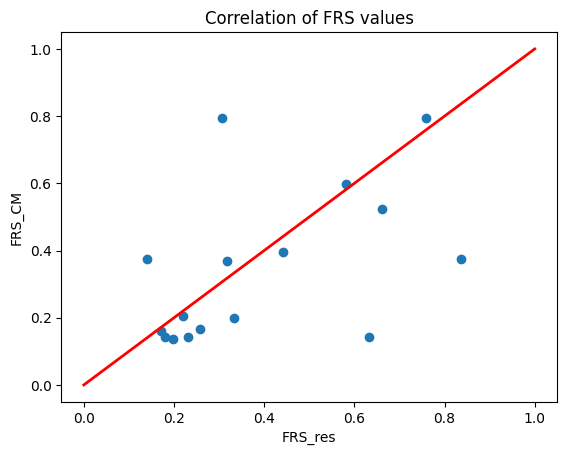

In [39]:
#compare the FRX_x and FRS_y columns to see if the FRS values are roughly the same
df_joined['FRS_res'] = df_joined['FRS_res'].astype(float)
df_joined['FRS_CM'] = df_joined['FRS_CM'].astype(float)

df_joined['FRS_res'].corr(df_joined['FRS_CM'])

#plot the FRS values for the samples with a minor allele and a compensatory mutation
plt.scatter(df_joined['FRS_res'], df_joined['FRS_CM']) 
#add a line through (1,1) to (0,0) to indicate a perfect correlation
plt.plot([0, 1], [0, 1], color='red', lw=2)
plt.xlabel('FRS_res')
plt.ylabel('FRS_CM')
plt.title('Correlation of FRS values')

plt.show()

In [40]:
#calculate correlation score
from scipy.stats import pearsonr
correlation, p_value = pearsonr(df_joined['FRS_res'], df_joined['FRS_CM'])
correlation, p_value

(np.float64(0.5025973171709659), np.float64(0.04723866503572301))

Check how Pearson correlation changes if we remove minor resistant mutations from the same sample and pnly keep the higher FRS

In [41]:
#Check how Pearson correlation changes if we remove minor resistant mutations from the same sample and pnly keep the higher FRS value
df_joined_max = df_joined.groupby('UNIQUEID').agg({'FRS_res':'max', 'FRS_CM':'max'}).reset_index()
correlation_max, p_value_max = pearsonr(df_joined_max['FRS_res'], df_joined_max['FRS_CM'])
correlation_max, p_value_max


(np.float64(0.696315663222213), np.float64(0.008193339610125321))

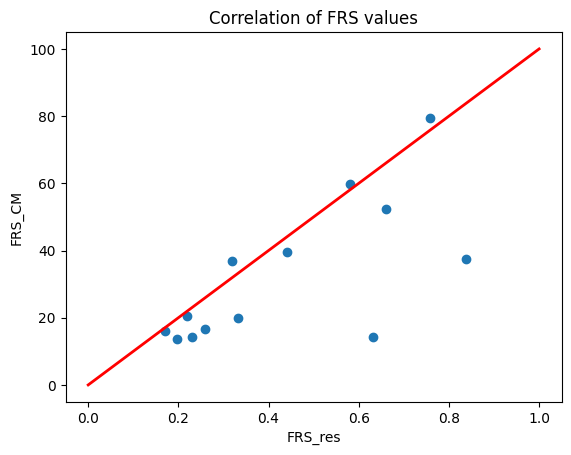

In [42]:
#plot correlation of FRS values for samples with a minor allele and a compensatory mutation, keeping only the higher FRS value
plt.scatter(df_joined_max['FRS_res'], df_joined_max['FRS_CM'])
plt.plot([0, 1], [0, 1], color='red', lw=2)
plt.xlabel('FRS_res')
plt.ylabel('FRS_CM')
plt.title('Correlation of FRS values')

# Set axes to display values as percentages without the percent sign
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0f}'.format(y * 100)))

#save figure in high resolution
plt.savefig('figures/FRS_correlation_CM.png', dpi=300)

plt.show()


In [43]:
#check how often FRS_x is higher than FRS_y in the joined max table
df_joined_max['FRS_x_higher'] = df_joined_max['FRS_res'] > df_joined_max['FRS_CM']
df_joined_max['FRS_x_higher'].value_counts()


FRS_x_higher
True     10
False     3
Name: count, dtype: int64

Check if the samples with mixed populations have evolved resistance or acquired another infection - look how many other minor alleles we see in these samples and if the FRS also correlates

In [44]:
res_minor_uniqueids = mutations_agg[(mutations_agg['R_MINOR_ALLELE']) & (~mutations_agg['R_MAJOR_ALLELE'])].UNIQUEID
len(res_minor_uniqueids)

438

In [45]:
res_minor = mutations[mutations.UNIQUEID.isin(res_minor_uniqueids) & (mutations.RESISTANT_MUTATION == True) & (mutations.IS_MINOR_ALLELE == True)]
other_minor = mutations[mutations.UNIQUEID.isin(res_minor_uniqueids) & (mutations.RESISTANT_MUTATION == False) & (mutations.IS_MINOR_ALLELE == True)]



In [46]:
len(res_minor), len(other_minor)

(600, 6372)

In [47]:
df_joined = pd.merge(res_minor[['UNIQUEID','MINOR_MUTATION','FRS']], other_minor[['UNIQUEID','MINOR_MUTATION','FRS']], on = 'UNIQUEID', how = 'inner')
df_joined.rename(columns = {'FRS_x':'FRS_res','FRS_y':'FRS_other','MINOR_MUTATION_x':'MINOR_MUTATION_res','MINOR_MUTATION_other':'MINOR_MUTATION_CM'}, inplace = True)
df_joined

,UNIQUEID,MINOR_MUTATION_res,FRS_res,MINOR_MUTATION_y,FRS_other
0,site.01.subj.DR0182.lab.DR0182.iso.1,S450L,0.127,A1075A,0.165
1,site.16.subj.001.lab.10398.iso.1,D435G,0.819,A1075A,0.116
2,site.16.subj.001.lab.10398.iso.1,D435G,0.819,I1106T,0.888
3,site.16.subj.001.lab.10398.iso.1,L452P,0.828,A1075A,0.116
4,site.16.subj.001.lab.10398.iso.1,L452P,0.828,I1106T,0.888
...,...,...,...,...,...
8751,site.07.subj.B2BA5DAF-6370-4E99-B3E9-782C61686...,1284_del_c,0.364,V994V,0.250
8752,site.07.subj.B2BA5DAF-6370-4E99-B3E9-782C61686...,1284_del_c,0.364,V996V,0.240
8753,site.07.subj.B2BA5DAF-6370-4E99-B3E9-782C61686...,1284_del_c,0.364,Y308Y,0.283
8754,site.07.subj.B2BA5DAF-6370-4E99-B3E9-782C61686...,1284_del_c,0.364,Y338Y,0.271


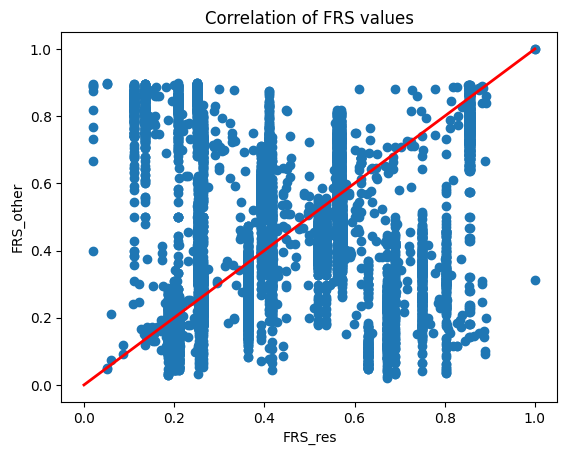

/var/folders/_3/8y_dwngx2614_y_52fzh1c4w0000gn/T/ipykernel_58588/2793423028.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_ids))


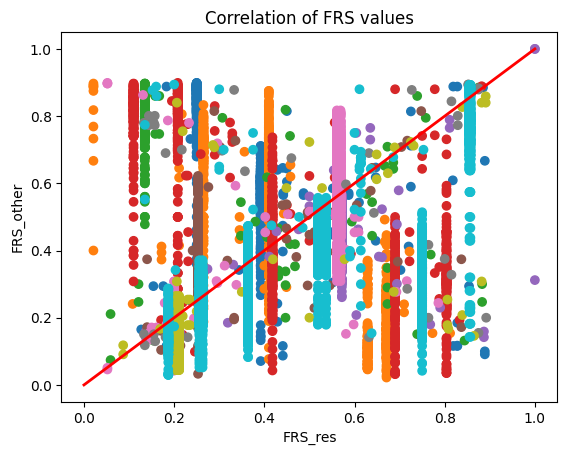

In [48]:
#compare the FRS_x and FRS_y columns to see if the FRS values are roughly the same
df_joined['FRS_res'] = df_joined['FRS_res'].astype(float)
df_joined['FRS_other'] = df_joined['FRS_other'].astype(float)

df_joined['FRS_res'].corr(df_joined['FRS_other'])

#plot the FRS values for the samples with a minor allele and a compensatory mutation
plt.scatter(df_joined['FRS_res'], df_joined['FRS_other']) 
#add a line through (1,1) to (0,0) to indicate a perfect correlation
plt.plot([0, 1], [0, 1], color='red', lw=2)
plt.xlabel('FRS_res')
plt.ylabel('FRS_other')
plt.title('Correlation of FRS values')

plt.show()

#can I plot thbis but colour the points by UNIQUEID 
# Create a color map for unique values in UNIQUEID
unique_ids = df_joined['UNIQUEID'].unique()
colors = plt.cm.get_cmap('tab10', len(unique_ids))

# Create a dictionary mapping UNIQUEID to a color
color_dict = {unique_id: colors(i) for i, unique_id in enumerate(unique_ids)}

# Map the UNIQUEID values to colors
mapped_colors = df_joined['UNIQUEID'].map(color_dict)

plt.scatter(df_joined['FRS_res'], df_joined['FRS_other'], c=mapped_colors)
plt.plot([0, 1], [0, 1], color='red', lw=2)
plt.xlabel('FRS_res')
plt.ylabel('FRS_other')
plt.title('Correlation of FRS values')

plt.show()

0.05605030842077141 0.40380363272593917


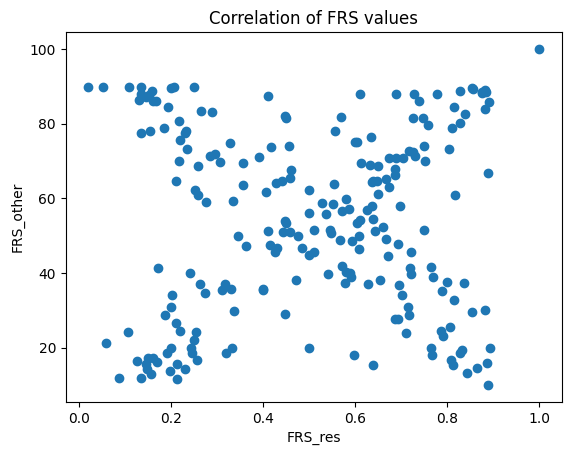

In [49]:
#Check how Pearson correlation changes if we remove minor resistant mutations from the same sample and only keep the higher FRS value
df_joined_max = df_joined.groupby('UNIQUEID').agg({'FRS_res':'max', 'FRS_other':'max'}).reset_index()
correlation_max, p_value_max = pearsonr(df_joined_max['FRS_res'], df_joined_max['FRS_other'])
print(correlation_max, p_value_max)

#plot correlation of FRS values for samples with a minor allele and a compensatory mutation, keeping only the higher FRS value
plt.scatter(df_joined_max['FRS_res'], df_joined_max['FRS_other'])
# plt.plot([0, 1], [0, 1], color='red', lw=2)
plt.xlabel('FRS_res')
plt.ylabel('FRS_other')
plt.title('Correlation of FRS values')

# Set axes to display values as percentages without the percent sign
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0f}'.format(y * 100)))

#save figure in high resolution
plt.savefig('figures/FRS_correlation_other.png', dpi=300)

plt.show()

[52.80251542 47.19748458]


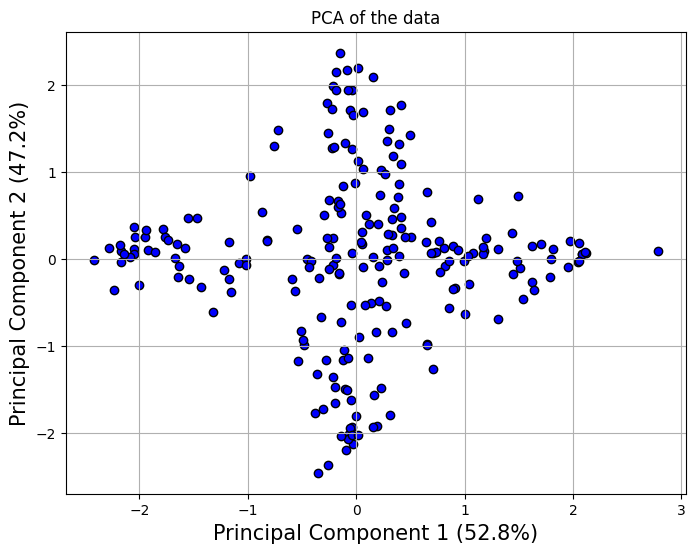

In [50]:
df = df_joined_max
X = df[['FRS_res', 'FRS_other']]

# Standardize data
X_scaled = StandardScaler().fit_transform(X)

# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
ex_var = pca.explained_variance_ratio_ * 100
print(ex_var)

# Plot PCA result
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c='blue', edgecolor='k')
plt.xlabel('Principal Component 1 ({}%)'.format(round(ex_var[0], 2)), fontsize=15)
plt.ylabel('Principal Component 2 ({}%)'.format(round(ex_var[1], 2)), fontsize=15)
plt.title('PCA of the data')
plt.grid(True)
plt.show()

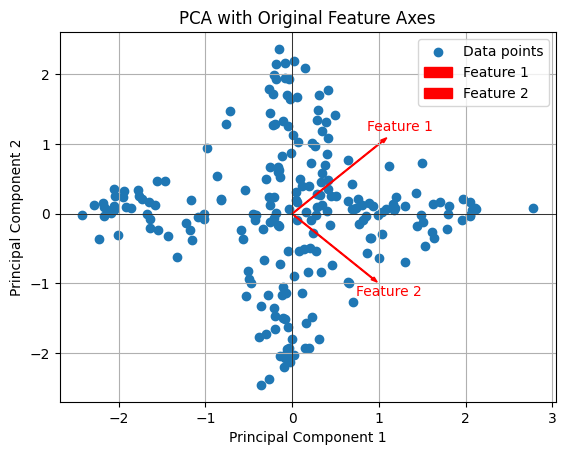

In [51]:
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Get the principal components
components = pca.components_

# Create a scatter plot of the PCA-transformed data
plt.scatter(X_pca[:, 0], X_pca[:, 1], label='Data points')

# Plot the original axes in PCA space (original feature space)
# Here we plot each feature's contribution as vectors
for i, (component, var) in enumerate(zip(components, pca.explained_variance_ratio_)):
    # Scale the vector by the explained variance (optional)
    vector = component * max(X_pca[:, 0]) * var
    plt.arrow(0, 0, vector[0], vector[1], color='r', width=0.01, head_width=0.05, label=f'Feature {i+1}')
    plt.text(vector[0] * 1.2, vector[1] * 1.2, f'Feature {i+1}', color='r', ha='center', va='center')

# Customize plot
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA with Original Feature Axes')
plt.legend()
plt.grid()

plt.show()

Check amount of minor alleles per resistant population sample... if high, probably an acquired infection (unrelated to original strain)

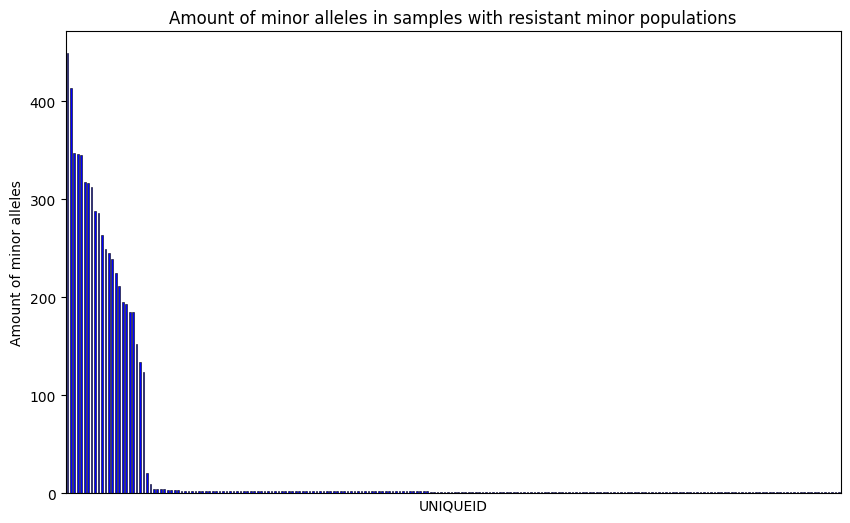

In [64]:
#count amount of minor alleles in samples with resistant minor populations

#count amount of minor alleles in samples with resistant minor populations
minor_resistant = mutations[(mutations.RESISTANT_MUTATION == True) & (mutations.IS_MINOR_ALLELE == True)]
minor_resistant['MINOR_MUTATION'].value_counts()

res_minor_uniqueids

mutations[(mutations.UNIQUEID.isin(res_minor_uniqueids)) & (mutations.RESISTANT_MUTATION == False) & (mutations.IS_MINOR_ALLELE == True)].UNIQUEID.value_counts().plot(kind='bar', figsize=(10, 6), color='blue', edgecolor='black', linewidth=0.4)

#remove x axis tick labels
plt.xticks([])

plt.xlabel('UNIQUEID')
plt.ylabel('Amount of minor alleles')
plt.title('Amount of minor alleles in samples with resistant minor populations')
plt.show()

# minor_resistant['UNIQUEID'].value_counts().plot(kind='bar', figsize=(10, 6), color='blue', edgecolor='black', linewidth=1.2)
# plt.xlabel('UNIQUEID')
# plt.ylabel('Amount of minor alleles')
# plt.title('Amount of minor alleles in samples with resistant minor populations')
# plt.show()

In [65]:
#choose an arbitrary cut-off for acquired vs emergent resistant: 5 SNPs
acquired = mutations[(mutations.UNIQUEID.isin(res_minor_uniqueids)) & (mutations.IS_MINOR_ALLELE == False) & (mutations.RESISTANT_MUTATION == False)].UNIQUEID.value_counts()>=2
acquired = acquired[acquired].index
len(acquired)

110

In [66]:
emergent = mutations[(mutations.UNIQUEID.isin(res_minor_uniqueids)) & (mutations.RESISTANT_MUTATION == False)].UNIQUEID.value_counts()<2
emergent = emergent[emergent].index
len(emergent)


176

In [67]:
38/(38+365)

0.09429280397022333

In [68]:
#check if acquired resistsnce is compensated more often than emergent resistance
acquired_resistant = mutations[(mutations.UNIQUEID.isin(acquired))]
emergent_resistant = mutations[(mutations.UNIQUEID.isin(emergent))]

print(acquired_resistant['COMPENSATORY_MUTATION'].value_counts())
print(emergent_resistant['COMPENSATORY_MUTATION'].value_counts())

COMPENSATORY_MUTATION
False    5442
True       10
Name: count, dtype: int64
COMPENSATORY_MUTATION
False    415
True       2
Name: count, dtype: int64


Try reading in entire mutation atbel and look for minor resistant population samples with more than 12 locations of minor alleles

In [69]:
import gzip
input_file = "/Users/viktoriabrunner/Documents/Studium/PhD/DPhil/cryptic-tables-v2.1.2/MUTATIONS.pkl.gz"
with gzip.open(input_file, "rb") as f:
        mutations_all = pd.read_pickle(f)

In [70]:
mutations_all.reset_index(inplace=True)
mutations_all

,UNIQUEID,GENE,MUTATION,REF,ALT,NUCLEOTIDE_NUMBER,NUCLEOTIDE_INDEX,GENE_POSITION,CODES_PROTEIN,INDEL_LENGTH,INDEL_NUCLEOTIDES,AMINO_ACID_NUMBER,AMINO_ACID_SEQUENCE,NUMBER_NUCLEOTIDE_CHANGES,IS_MINOR_ALLELE,MINOR_MUTATION,FRS
0,site.01.subj.DR0682.lab.DR0682.iso.1,fadD34,S16W,tcg,tgg,NaN,NaN,16.0,True,NaN,nan,16.0,W,1.0,False,None,NaN
1,site.01.subj.DR0682.lab.DR0682.iso.1,fadD34,T26S,act,tct,NaN,NaN,26.0,True,NaN,nan,26.0,S,1.0,False,None,NaN
2,site.01.subj.DR0682.lab.DR0682.iso.1,Rv1231c,L60L,ctg,ctc,NaN,NaN,60.0,True,NaN,nan,60.0,L,1.0,False,None,NaN
3,site.01.subj.DR0682.lab.DR0682.iso.1,nth,P2R,ccc,cgc,NaN,NaN,2.0,True,NaN,nan,2.0,R,1.0,False,None,NaN
4,site.01.subj.DR0682.lab.DR0682.iso.1,Rv0465c,C106R,tgc,cgc,NaN,NaN,106.0,True,NaN,nan,106.0,R,1.0,False,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57566027,site.07.subj.FD_127_2228.lab.13_0613254.iso.1,Rv0881,G115R,ggc,cgc,NaN,NaN,115.0,True,NaN,nan,115.0,R,1.0,False,None,NaN
57566028,site.07.subj.FD_127_2228.lab.13_0613254.iso.1,Rv0890c,P866A,ccc,gcc,NaN,NaN,866.0,True,NaN,nan,866.0,A,1.0,False,None,NaN
57566029,site.07.subj.FD_127_2228.lab.13_0613254.iso.1,Rv1514c,S159S,tca,tcg,NaN,NaN,159.0,True,NaN,nan,159.0,S,1.0,False,None,NaN
57566030,site.07.subj.FD_127_2228.lab.13_0613254.iso.1,Rv3113,Y81D,tat,gat,NaN,NaN,81.0,True,NaN,nan,81.0,D,1.0,False,None,NaN


In [71]:
#add resistance and compensatory mutation flags to mutations table: need to check for minor allele before concatenating GENE_MUTATION 
# use resistance catalogue of WHO instead?
mutations_all['GENE_MUTATION'] = np.where(
    mutations_all['IS_MINOR_ALLELE'],  # Condition: if IS_MINOR_ALLELE is True
    mutations_all['GENE'].astype(str) + '_' + mutations_all['MINOR_MUTATION'].astype(str),  # Then: use GENE + MINOR_MUTATION
    mutations_all['GENE'].astype(str) + '_' + mutations_all['MUTATION'].astype(str)  # Else: use GENE + MUTATION
)
    
mutations_all['RESISTANT_MUTATION'] = mutations_all['GENE_MUTATION'].isin(resistance_mutations)
mutations_all['COMPENSATORY_MUTATION'] = mutations_all['GENE_MUTATION'].isin(compensatory_mutations)

mutations_all

,UNIQUEID,GENE,MUTATION,REF,ALT,NUCLEOTIDE_NUMBER,NUCLEOTIDE_INDEX,GENE_POSITION,CODES_PROTEIN,INDEL_LENGTH,INDEL_NUCLEOTIDES,AMINO_ACID_NUMBER,AMINO_ACID_SEQUENCE,NUMBER_NUCLEOTIDE_CHANGES,IS_MINOR_ALLELE,MINOR_MUTATION,FRS,GENE_MUTATION,RESISTANT_MUTATION,COMPENSATORY_MUTATION
0,site.01.subj.DR0682.lab.DR0682.iso.1,fadD34,S16W,tcg,tgg,NaN,NaN,16.0,True,NaN,nan,16.0,W,1.0,False,None,NaN,fadD34_S16W,False,False
1,site.01.subj.DR0682.lab.DR0682.iso.1,fadD34,T26S,act,tct,NaN,NaN,26.0,True,NaN,nan,26.0,S,1.0,False,None,NaN,fadD34_T26S,False,False
2,site.01.subj.DR0682.lab.DR0682.iso.1,Rv1231c,L60L,ctg,ctc,NaN,NaN,60.0,True,NaN,nan,60.0,L,1.0,False,None,NaN,Rv1231c_L60L,False,False
3,site.01.subj.DR0682.lab.DR0682.iso.1,nth,P2R,ccc,cgc,NaN,NaN,2.0,True,NaN,nan,2.0,R,1.0,False,None,NaN,nth_P2R,False,False
4,site.01.subj.DR0682.lab.DR0682.iso.1,Rv0465c,C106R,tgc,cgc,NaN,NaN,106.0,True,NaN,nan,106.0,R,1.0,False,None,NaN,Rv0465c_C106R,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57566027,site.07.subj.FD_127_2228.lab.13_0613254.iso.1,Rv0881,G115R,ggc,cgc,NaN,NaN,115.0,True,NaN,nan,115.0,R,1.0,False,None,NaN,Rv0881_G115R,False,False
57566028,site.07.subj.FD_127_2228.lab.13_0613254.iso.1,Rv0890c,P866A,ccc,gcc,NaN,NaN,866.0,True,NaN,nan,866.0,A,1.0,False,None,NaN,Rv0890c_P866A,False,False
57566029,site.07.subj.FD_127_2228.lab.13_0613254.iso.1,Rv1514c,S159S,tca,tcg,NaN,NaN,159.0,True,NaN,nan,159.0,S,1.0,False,None,NaN,Rv1514c_S159S,False,False
57566030,site.07.subj.FD_127_2228.lab.13_0613254.iso.1,Rv3113,Y81D,tat,gat,NaN,NaN,81.0,True,NaN,nan,81.0,D,1.0,False,None,NaN,Rv3113_Y81D,False,False


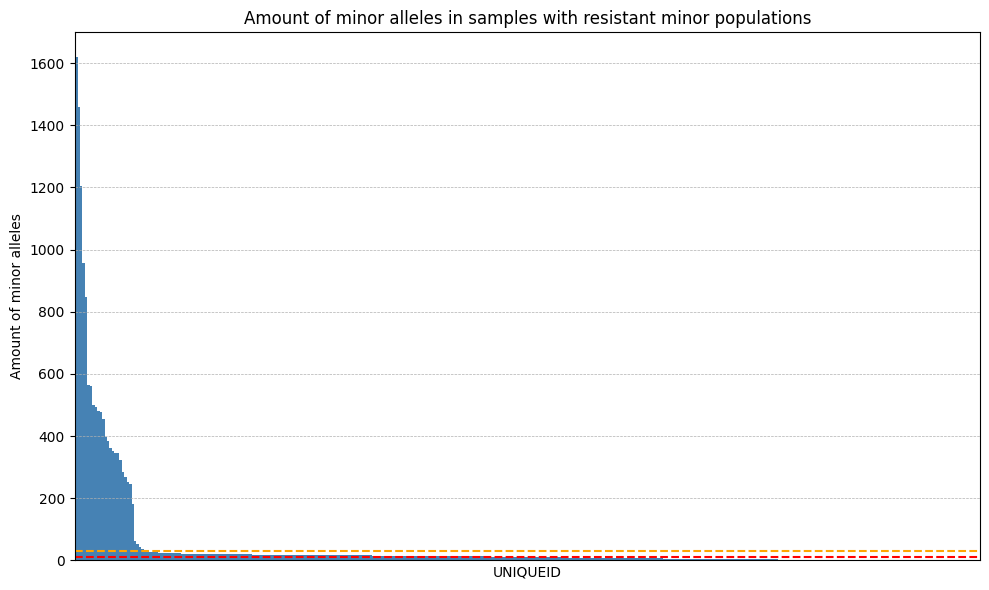

In [154]:
mutations_count_by_sample = mutations_all[(mutations_all.UNIQUEID.isin(res_minor_uniqueids)) & (mutations_all.RESISTANT_MUTATION == False) & (mutations_all.IS_MINOR_ALLELE == True)].UNIQUEID.value_counts()

mutations_count_by_sample.plot(kind='bar', figsize=(10, 6), color='#4682B4', edgecolor='black', linewidth=0.0, width = 1.0)

#remove x axis tick labels
plt.xticks([])

#add horizontal line for cut-off of emergence definition
plt.axhline(y=12, color='red', linestyle='--')
plt.axhline(y=30, color='orange', linestyle='--')

plt.xlabel('UNIQUEID')
plt.ylabel('Amount of minor alleles')
plt.title('Amount of minor alleles in samples with resistant minor populations')

# Customize the y-axis ticks and grid
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', linewidth=0.5)

# Improve spacing and layout
plt.tight_layout()

#save figure in high resolution
plt.savefig('figures/minor_SNP_distribution.png', dpi=300)

plt.show()

In [155]:
mutations_count_by_sample= pd.DataFrame(mutations_count_by_sample)
mutations_count_by_sample.rename(columns={'count': 'mutations'}, inplace=True)
mutations_count_by_sample.reset_index(inplace=True) 
print(f"There are {len(mutations_count_by_sample)} samples with minor alleles and no resistant major alleles")

There are 369 samples with minor alleles and no resistant major alleles


In [156]:
mutations_hist =  mutations_count_by_sample.groupby('mutations').count()
mutations_hist

,UNIQUEID
mutations,
1,34
2,23
3,25
4,18
5,15
6,14
7,12
8,13
9,14


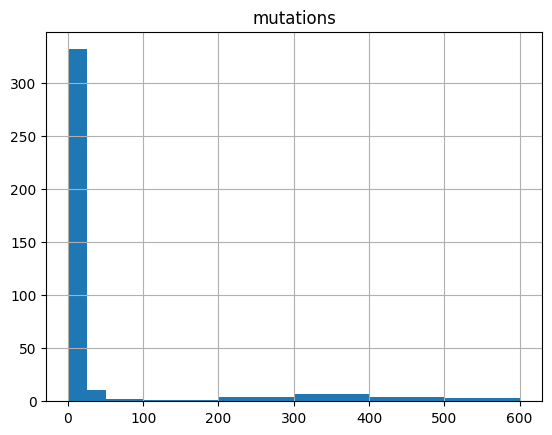

In [162]:
axes = mutations_count_by_sample.hist(bins=[1,25,50,100,200,300,400,500,600])

In [163]:
#choose the cut-off normally chosen for distinguishing direcrtly related samples: 12 SNPs
acquired = mutations_all[(mutations_all.UNIQUEID.isin(res_minor_uniqueids)) & (mutations_all.RESISTANT_MUTATION == False) & (mutations_all.IS_MINOR_ALLELE == True)].UNIQUEID.value_counts()>=12
acquired = acquired[acquired].index
len(acquired)

179

In [164]:
emergent = mutations_all[(mutations_all.UNIQUEID.isin(res_minor_uniqueids)) & (mutations_all.RESISTANT_MUTATION == False) & (mutations_all.IS_MINOR_ALLELE == True)].UNIQUEID.value_counts()<12
emergent = emergent[emergent].index
len(emergent)


190

In [165]:
#check if acquired resistance is compensated more often than emergent resistance
acquired_resistant = mutations_all[(mutations_all.UNIQUEID.isin(acquired) & (mutations_all.RESISTANT_MUTATION == False) & (mutations_all.IS_MINOR_ALLELE == True))]
emergent_resistant = mutations_all[(mutations_all.UNIQUEID.isin(emergent) & (mutations_all.RESISTANT_MUTATION == False) & (mutations_all.IS_MINOR_ALLELE == True))]

print(acquired_resistant['COMPENSATORY_MUTATION'].value_counts())
print(emergent_resistant['COMPENSATORY_MUTATION'].value_counts())

COMPENSATORY_MUTATION
False    16189
True         6
Name: count, dtype: int64
COMPENSATORY_MUTATION
False    928
True       7
Name: count, dtype: int64


In [166]:
emergent_resistant.GENE.value_counts()[:20]

GENE
embB      174
katG      110
rpoB       97
gid        92
pncA       85
gyrA       75
embA       48
ethA       46
rrs        39
mmpL5      36
fabG1      34
Rv0678     23
rpsL       22
eis        14
gyrB       14
inhA        8
tlyA        6
rplC        6
ddn         4
pepQ        2
Name: count, dtype: int64

In [167]:
acquired_resistant.GENE.value_counts()[:20]

GENE
rpoB     6275
rrs      1759
embB     1218
embA     1025
gyrA      928
gyrB      630
fabG1     545
gid       544
inhA      535
rplC      495
pepQ      493
mmpL5     310
rpsL      274
ethA      235
katG      223
pncA      184
ddn       175
tlyA      137
atpE      134
eis        52
Name: count, dtype: int64